In [52]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import (
    Input,
    Sequential,
    layers,
    callbacks,
    optimizers,
)
from conlanger.models.WGANGP import WGANGP
from conlanger.utils import display_rows, get_closest_matches, get_exact_matches
from IPython.display import display



In [53]:
USE_GPU = True
TRAIN = True

In [54]:
tf.test.gpu_device_name()

if USE_GPU:
    with tf.device('/gpu:0'):
        gpu = tf.config.list_physical_devices("GPU")
        if not gpu:
            raise

I0000 00:00:1724660429.751217    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724660429.752593    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724660429.754248    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1724660429.755692    4379 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [55]:
IMAGE_SIZE = 24
CHANNELS = 1
BATCH_SIZE = 256
Z_DIM = IMAGE_SIZE * IMAGE_SIZE
LEARNING_RATE = 0.001
EPOCHS = 55
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = False
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [56]:
data = np.load("./data/language_phonemes.npz", allow_pickle=True)
language_phonemes_selected = data["language_phonemes_selected"]
language_names_selected = data["language_names_selected"]

# pad to IMAGE_SIZE * IMAGE_SIZE
X = language_phonemes_selected.copy()
X = np.hstack([X, np.full((X.shape[0], IMAGE_SIZE - X.shape[1], X.shape[2]), 0)])
X = np.dstack([X, np.full((X.shape[0], X.shape[1], IMAGE_SIZE - X.shape[2]), 0)])
X = np.expand_dims(X, axis=3)

assert language_phonemes_selected.shape[0] == language_names_selected.shape[0]
(language_phonemes_selected.shape, language_names_selected.shape, X.shape)

((2740, 22, 24), (2740,), (2740, 24, 24, 1))

In [57]:
shape = X.shape[1:]
width = shape[0]

print(shape)

critic = Sequential(
    [
        Input(shape=shape),
        layers.Conv2D(IMAGE_SIZE, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Conv2D(IMAGE_SIZE * 2, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 4, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 8, kernel_size=2, strides=2, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE * 16, kernel_size=2, strides=1, padding="same"),
        layers.LeakyReLU(0.2),
        layers.Dropout(0.3),
        layers.Conv2D(1, kernel_size=2, strides=1, padding="valid"),
        layers.Flatten(),
    ],
    name="critic",
)
critic.summary()

(24, 24, 1)


Model: "critic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_30 (Conv2D)              │ (None, 12, 12, 24)     │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_30 (LeakyReLU)      │ (None, 12, 12, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_31 (Conv2D)              │ (None, 6, 6, 48)       │         4,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_31 (LeakyReLU)      │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 6, 6, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_32 (Conv2D)              │ (None, 3, 3, 96)       │        18,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_32 (LeakyReLU)      │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 2, 2, 192)      │        73,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_33 (LeakyReLU)      │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 2, 2, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 2, 2, 384)      │       295,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_34 (LeakyReLU)      │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 2, 2, 384)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 1, 1, 1)        │         1,537 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 394,057 (1.50 MB)

 Trainable params: 394,057 (1.50 MB)

 Non-trainable params: 0 (0.00 B)

In [58]:
generator = Sequential(
    [
        Input(shape=(Z_DIM,)),
        layers.Reshape((1, 1, Z_DIM)),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 8, kernel_size=4, strides=1, padding="valid", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 8, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        # layers.Conv2DTranspose(
        #     IMAGE_SIZE * 4, kernel_size=4, strides=2, padding="same", use_bias=False
        # ),
        layers.Dropout(0.3),
        layers.Conv2D(
            IMAGE_SIZE * 4, kernel_size=3, strides=1, padding="same", use_bias=False
        ),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE * 2, kernel_size=4, strides=2, padding="same", use_bias=False
        ),
        # layers.Dropout(0.3),
        # layers.Conv2D(
        #     IMAGE_SIZE * 2, kernel_size=3, strides=1, padding="same", use_bias=False
        # ),
        # layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=3, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            IMAGE_SIZE, kernel_size=4, strides=1, padding="same", use_bias=False
        ),
        layers.Dropout(0.3),
        layers.Conv2D(IMAGE_SIZE, kernel_size=3, strides=1, padding="same", use_bias=False),
        layers.BatchNormalization(momentum=0.9),
        layers.LeakyReLU(0.2),
        layers.Conv2DTranspose(
            CHANNELS, kernel_size=2, strides=1, padding="same", activation="sigmoid"
        ),
    ],
    name="generator",
)
generator.summary()

Model: "generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ reshape_3 (Reshape)             │ (None, 1, 1, 576)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_15             │ (None, 4, 4, 192)      │     1,769,472 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 4, 4, 192)      │       331,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 4, 4, 192)      │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_35 (LeakyReLU)      │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 4, 4, 192)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 4, 4, 96)       │       165,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 4, 4, 96)       │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_36 (LeakyReLU)      │ (None, 4, 4, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_16             │ (None, 8, 8, 48)       │        73,728 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_37 (LeakyReLU)      │ (None, 8, 8, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_17             │ (None, 24, 24, 24)     │        18,432 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_38 (LeakyReLU)      │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_18             │ (None, 24, 24, 24)     │         9,216 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 24, 24, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 24)     │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 24, 24, 24)     │            96 │
│ (BatchNormalization)            │                        │             

 Total params: 2,380,321 (9.08 MB)

 Trainable params: 2,379,649 (9.08 MB)

 Non-trainable params: 672 (2.62 KB)

In [59]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [60]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [61]:
import matplotlib.pyplot as plt


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        if epoch % 10 == 0:
            random_latent_vectors = tf.random.normal(
                shape=(self.num_img, self.latent_dim)
            )
            generated_images = self.model.generator(random_latent_vectors)
            generated_images = generated_images.numpy()
            plt.figure(figsize=(IMAGE_SIZE, IMAGE_SIZE))

            for i in range(10):
                _ = plt.subplot(1, 10, i + 1)
                plt.imshow(generated_images[i].astype("float32"), cmap="copper_r")
                plt.axis("off")
            
            plt.show()

Epoch 1/55


I0000 00:00:1724660437.217679    4590 service.cc:146] XLA service 0x7a1e100081c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724660437.217696    4590 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3080 Laptop GPU, Compute Capability 8.6
2024-08-26 09:20:37.512234: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-26 09:20:38.531106: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


1/3 ━━━━━━━━━━━━━━━━━━━━ 1:14 37s/step - c_gp: 0.8061 - c_loss: 7.7821 - c_wass_loss: -0.2792 - g_loss: 0.6834

I0000 00:00:1724660467.617644    4590 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15s/step - c_gp: 0.6040 - c_loss: 4.3959 - c_wass_loss: -1.6446 - g_loss: 2.9589  

W0000 00:00:1724660496.930373    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.939955    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.940545    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.941102    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.941883    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.943055    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.943791    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.944362    4379 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1724660496.944938    4379 gp

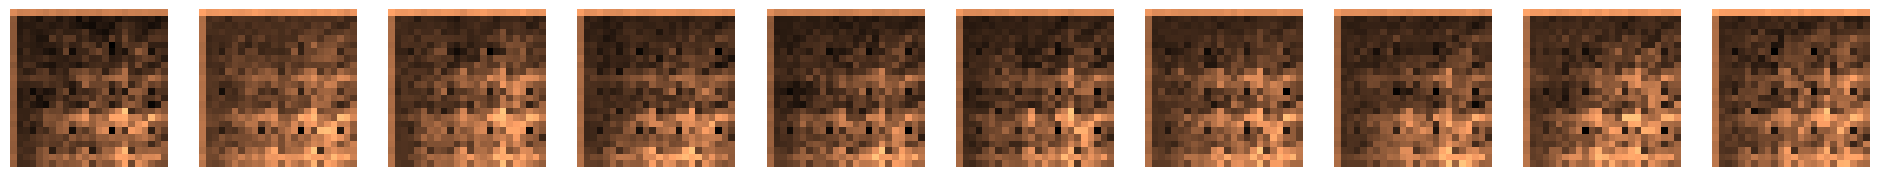

3/3 ━━━━━━━━━━━━━━━━━━━━ 67s 15s/step - c_gp: 0.5621 - c_loss: 3.4950 - c_wass_loss: -2.1261 - g_loss: 3.7117
Epoch 2/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 3/55


2024-08-26 09:21:37.300464: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-08-26 09:21:37.300491: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 09:21:37.300506: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730
/home/pappa/anaconda3/envs/conlanger/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.4964 - c_loss: -13.9332 - c_wass_loss: -18.8977 - g_loss: 22.3894
Epoch 4/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 915us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 5/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.4720 - c_loss: -14.1354 - c_wass_loss: -18.8557 - g_loss: 20.2846

2024-08-26 09:21:37.644689: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 09:21:37.644711: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.5277 - c_loss: -13.6330 - c_wass_loss: -18.9100 - g_loss: 19.2087
Epoch 6/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 7/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.7724 - c_loss: -12.1536 - c_wass_loss: -19.8776 - g_loss: 14.7055

2024-08-26 09:21:37.977619: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.6150 - c_loss: -12.0733 - c_wass_loss: -18.2237 - g_loss: 16.1364
Epoch 8/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 887us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 9/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - c_gp: 0.5117 - c_loss: -10.5992 - c_wass_loss: -15.7167 - g_loss: 14.7626

2024-08-26 09:21:38.308693: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 09:21:38.308717: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.4549 - c_loss: -10.4397 - c_wass_loss: -14.9887 - g_loss: 14.4129
Epoch 10/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 964us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 11/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - c_gp: 0.3342 - c_loss: -9.3467 - c_wass_loss: -12.6886 - g_loss: 12.8252

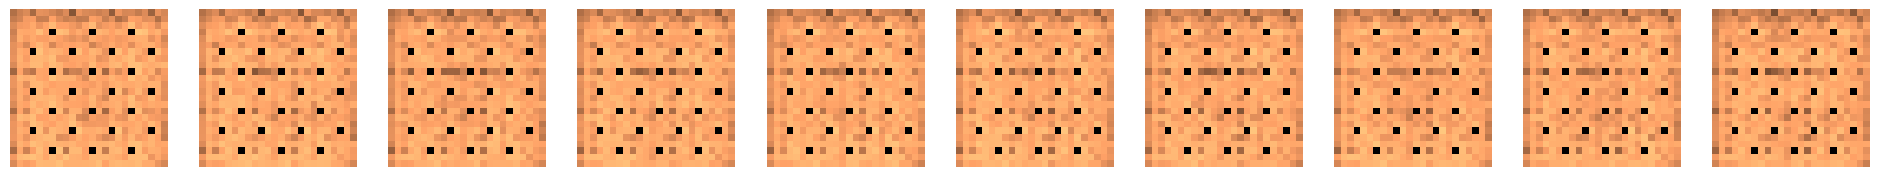

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 231ms/step - c_gp: 0.3412 - c_loss: -9.3063 - c_wass_loss: -12.7180 - g_loss: 12.6889
Epoch 12/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 954us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 13/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.2717 - c_loss: -8.8520 - c_wass_loss: -11.5695 - g_loss: 12.5211

2024-08-26 09:21:39.226674: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.2715 - c_loss: -8.7674 - c_wass_loss: -11.4825 - g_loss: 12.1135
Epoch 14/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 866us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 15/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1490 - c_loss: -8.2757 - c_wass_loss: -9.7659 - g_loss: 12.3774
Epoch 16/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 17/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - c_gp: 0.2175 - c_loss: -8.1897 - c_wass_loss: -10.3650 - g_loss: 10.7499

2024-08-26 09:21:39.888329: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-08-26 09:21:39.888360: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.2290 - c_loss: -8.1952 - c_wass_loss: -10.4849 - g_loss: 10.5232
Epoch 18/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 19/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - c_gp: 0.1074 - c_loss: -7.8259 - c_wass_loss: -8.8999 - g_loss: 11.4008

2024-08-26 09:21:40.219746: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1359 - c_loss: -7.8500 - c_wass_loss: -9.2091 - g_loss: 11.0433
Epoch 20/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 905us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 21/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - c_gp: 0.1813 - c_loss: -7.6243 - c_wass_loss: -9.4377 - g_loss: 9.2312

2024-08-26 09:21:40.549836: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.1918 - c_loss: -7.5664 - c_wass_loss: -9.4844 - g_loss: 9.1333

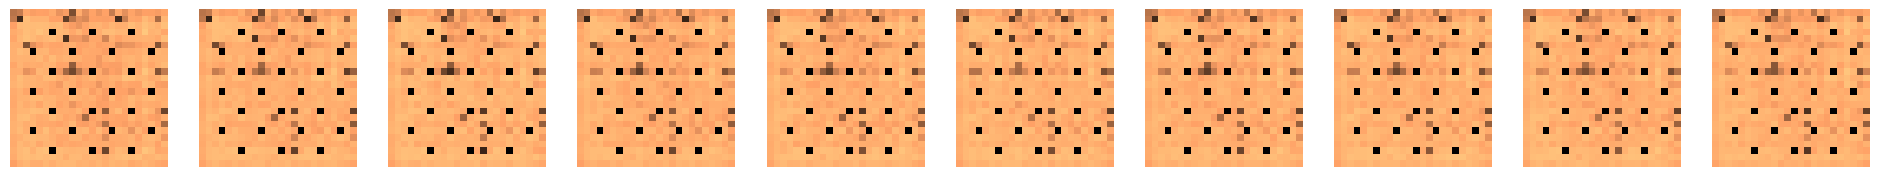

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - c_gp: 0.1904 - c_loss: -7.5508 - c_wass_loss: -9.4548 - g_loss: 9.1328
Epoch 22/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 23/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - c_gp: 0.1434 - c_loss: -7.4960 - c_wass_loss: -8.9299 - g_loss: 9.4266

2024-08-26 09:21:40.978287: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.2011 - c_loss: -7.3915 - c_wass_loss: -9.4021 - g_loss: 8.8867
Epoch 24/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 25/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - c_gp: 0.1424 - c_loss: -7.2637 - c_wass_loss: -8.6874 - g_loss: 7.9217

2024-08-26 09:21:41.308221: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1470 - c_loss: -7.2103 - c_wass_loss: -8.6806 - g_loss: 8.0929
Epoch 26/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 27/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - c_gp: 0.1838 - c_loss: -6.9877 - c_wass_loss: -8.8253 - g_loss: 6.1571

2024-08-26 09:21:41.639095: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.1844 - c_loss: -6.9182 - c_wass_loss: -8.7627 - g_loss: 5.8887
Epoch 28/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 939us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 29/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1342 - c_loss: -6.7885 - c_wass_loss: -8.1308 - g_loss: 6.0813
Epoch 30/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 860us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 31/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - c_gp: 0.2026 - c_loss: -6.5884 - c_wass_loss: -8.6147 - g_loss: 4.9073

2024-08-26 09:21:42.308234: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.1906 - c_loss: -6.6368 - c_wass_loss: -8.5430 - g_loss: 4.9912

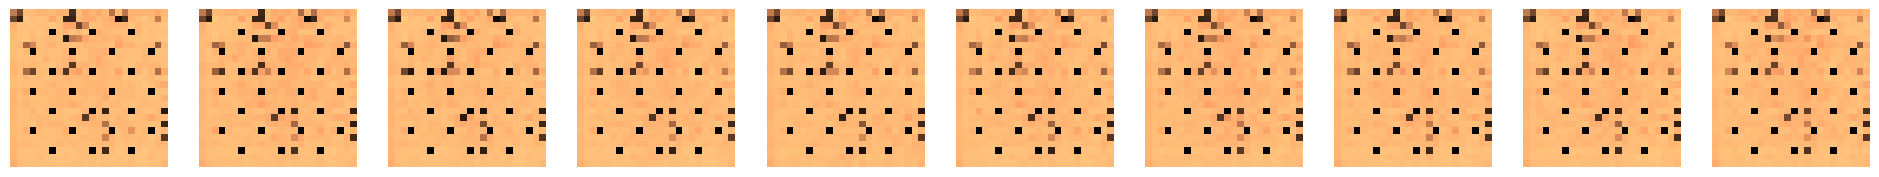

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - c_gp: 0.1869 - c_loss: -6.6415 - c_wass_loss: -8.5101 - g_loss: 5.0450
Epoch 32/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 33/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - c_gp: 0.1668 - c_loss: -6.5310 - c_wass_loss: -8.1993 - g_loss: 4.6834

2024-08-26 09:21:42.735657: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.1566 - c_loss: -6.5144 - c_wass_loss: -8.0802 - g_loss: 4.5833
Epoch 34/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 947us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 35/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - c_gp: 0.1519 - c_loss: -6.5723 - c_wass_loss: -8.0916 - g_loss: 4.7865

2024-08-26 09:21:43.066776: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1660 - c_loss: -6.5550 - c_wass_loss: -8.2151 - g_loss: 3.7964
Epoch 36/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 37/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.1558 - c_loss: -6.3450 - c_wass_loss: -7.9029 - g_loss: 2.7533
Epoch 38/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 39/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - c_gp: 0.1471 - c_loss: -6.3899 - c_wass_loss: -7.8605 - g_loss: 2.4634
Epoch 40/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 900us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 41/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - c_gp: 0.1254 - c_loss: -6.2141 - c_wass_loss: -7.4676 - g_loss: 3.5647

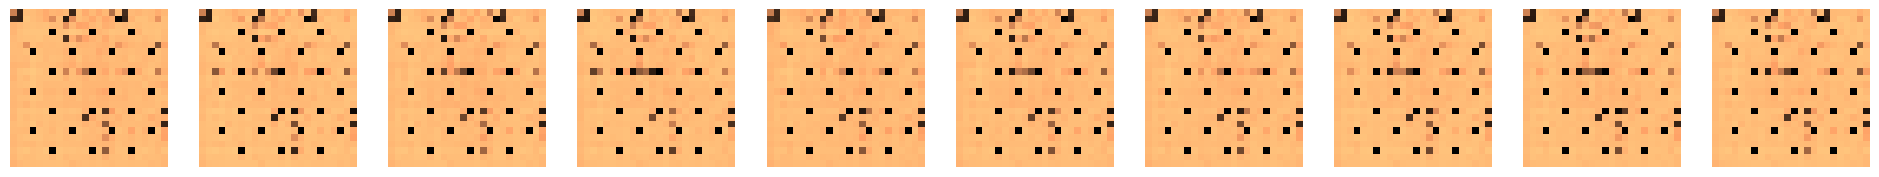

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - c_gp: 0.1233 - c_loss: -6.2278 - c_wass_loss: -7.4608 - g_loss: 3.6267
Epoch 42/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 934us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 43/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.1333 - c_loss: -6.3008 - c_wass_loss: -7.6341 - g_loss: 2.9992

2024-08-26 09:21:44.477119: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - c_gp: 0.1464 - c_loss: -6.3147 - c_wass_loss: -7.7787 - g_loss: 3.1365
Epoch 44/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 893us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 45/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - c_gp: 0.1371 - c_loss: -6.0361 - c_wass_loss: -7.4074 - g_loss: 2.7283

2024-08-26 09:21:44.807271: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.1202 - c_loss: -6.0938 - c_wass_loss: -7.2955 - g_loss: 3.1947
Epoch 46/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 47/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1214 - c_loss: -6.1295 - c_wass_loss: -7.3431 - g_loss: 3.0538
Epoch 48/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 49/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - c_gp: 0.1368 - c_loss: -5.9128 - c_wass_loss: -7.2811 - g_loss: 4.7267

2024-08-26 09:21:45.473135: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1424 - c_loss: -5.9513 - c_wass_loss: -7.3756 - g_loss: 4.3290
Epoch 50/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 931us/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 51/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - c_gp: 0.1419 - c_loss: -6.1161 - c_wass_loss: -7.5353 - g_loss: 4.4566

2024-08-26 09:21:45.808228: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - c_gp: 0.1446 - c_loss: -6.0458 - c_wass_loss: -7.4921 - g_loss: 4.1229

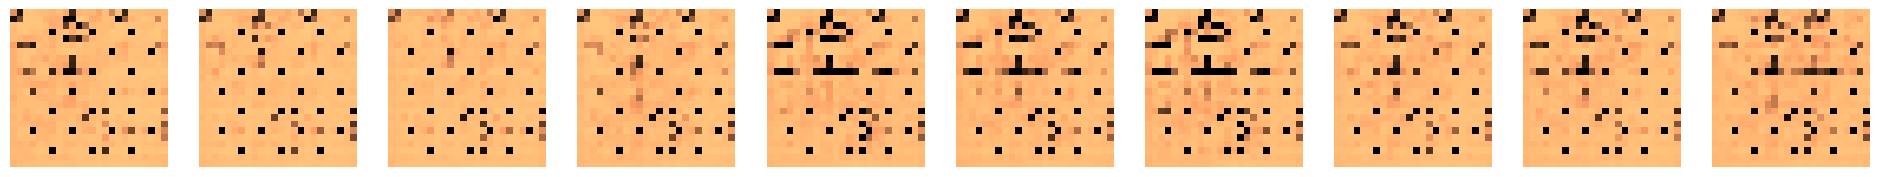

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - c_gp: 0.1426 - c_loss: -6.0312 - c_wass_loss: -7.4576 - g_loss: 4.0787
Epoch 52/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 53/55
1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - c_gp: 0.1358 - c_loss: -5.7199 - c_wass_loss: -7.0774 - g_loss: 3.7998

2024-08-26 09:21:46.239532: I tensorflow/core/framework/local_rendezvous.cc:423] Local rendezvous recv item cancelled. Key hash: 6850791237252506730


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - c_gp: 0.1290 - c_loss: -5.2359 - c_wass_loss: -6.5257 - g_loss: 2.9875
Epoch 54/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - c_gp: 0.0000e+00 - c_loss: 0.0000e+00 - c_wass_loss: 0.0000e+00 - g_loss: 0.0000e+00
Epoch 55/55
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - c_gp: 0.0665 - c_loss: -3.3303 - c_wass_loss: -3.9952 - g_loss: 0.2964


In [62]:

if TRAIN:
    wgangp.fit(
        X,
        epochs=EPOCHS,
        steps_per_epoch=3,
        callbacks=[
            ImageGenerator(num_img=10, latent_dim=Z_DIM),
        ],
    )

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 783ms/step
(18, 24, 24, 1)


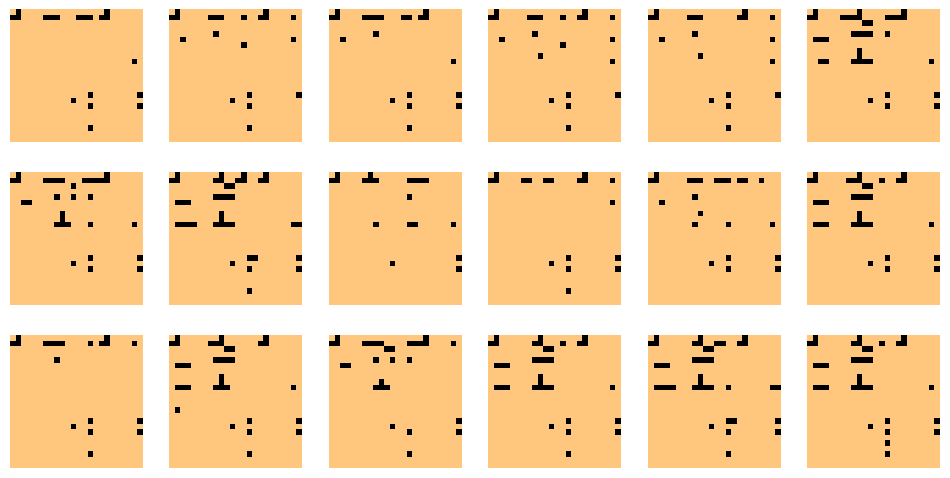

In [63]:
if TRAIN:
    
    noise = np.random.normal(size=(18, Z_DIM))
    generated_languages = generator.predict(noise)

    np.savez_compressed(
        "./data/generated_languages.npz",
        generated_languages=generated_languages,
    )

else:
    data = np.load("./data/generated_languages.npz", allow_pickle=True)
    generated_languages = data["generated_languages"]

print(generated_languages.shape)

# normalise
generated_languages = (generated_languages-np.min(generated_languages))/(np.max(generated_languages)-np.min(generated_languages))
# sigmoid
generated_languages = np.where(generated_languages > 0.5, np.ones(generated_languages.shape), np.zeros(generated_languages.shape))


display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))

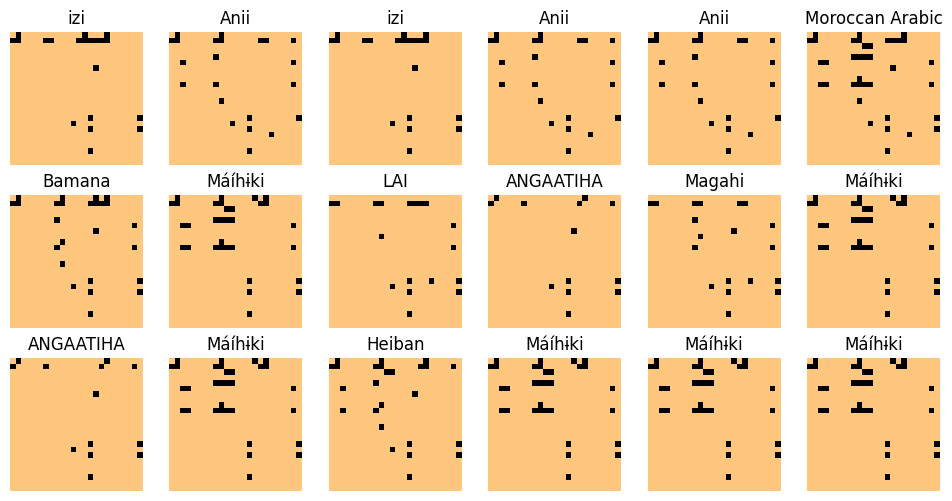

0.01765046296296296

In [64]:
# find closest matches

closest_idx, closest, closest_diff = get_closest_matches(X, generated_languages, n=18)
closest_language_names = np.take(language_names_selected, closest_idx)

display_rows(closest, titles=closest_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))

np.mean(closest_diff)

In [65]:
# find exact matches

exact_idx = get_exact_matches(X, generated_languages)
exact = np.take(X, exact_idx)
exact_language_names = np.take(language_names_selected, exact_idx)

if len(exact_idx) > 0:
    display_rows(exact, titles=exact_language_names, cmap="copper_r", r=3, c=6, size=(12, 6))
else:
    print("No exact matches. Noice!")

X.shape, exact_idx.shape

No exact matches. Noice!


((2740, 24, 24, 1), (0,))

In [66]:
# load the phoneme table dataframes

cons_pl_tbl_df = pd.read_csv(
    "./data/consonants_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
    on_bad_lines="warn",
)

cons_npl_tbl_df = pd.read_csv(
    "./data/consonants_non_plumonic.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_coart_tbl_df = pd.read_csv(
    "./data/consonants_coarticulated.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

vowels_tbl_df = pd.read_csv(
    "./data/vowels.csv",
    dtype=str,
    index_col=[0],
    keep_default_na=False,
    na_values=["-1"],
)

cons_pl_tbl_df.shape, cons_npl_tbl_df.shape, cons_coart_tbl_df.shape, vowels_tbl_df.shape

((14, 24), (7, 10), (3, 4), (7, 10))

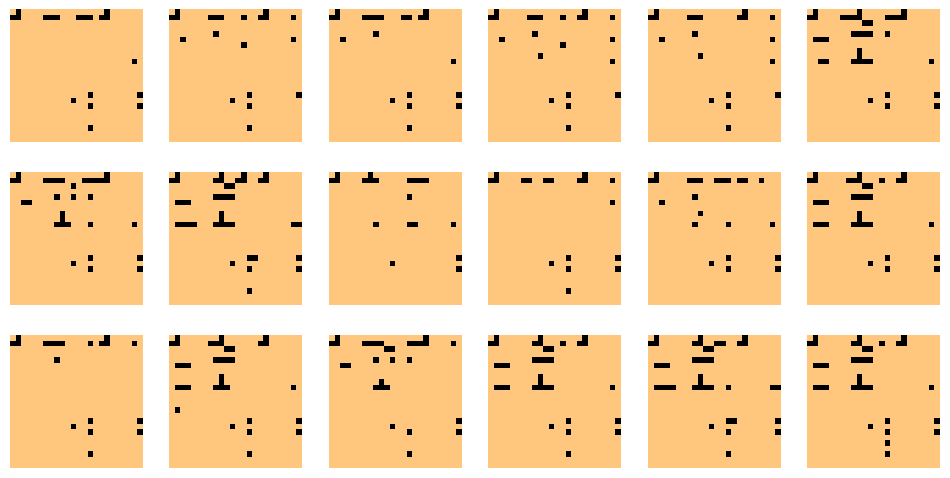

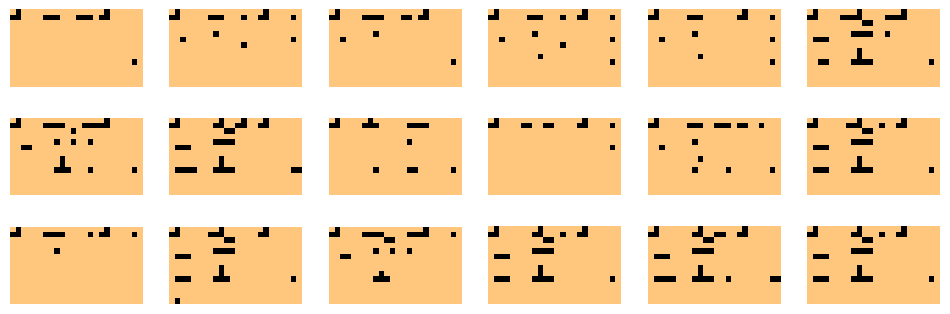

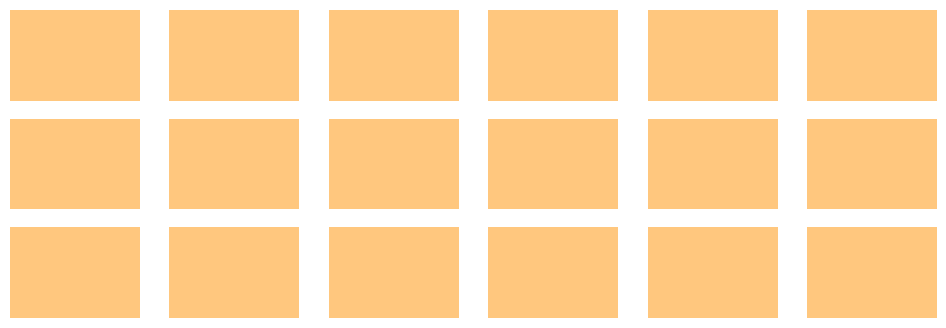

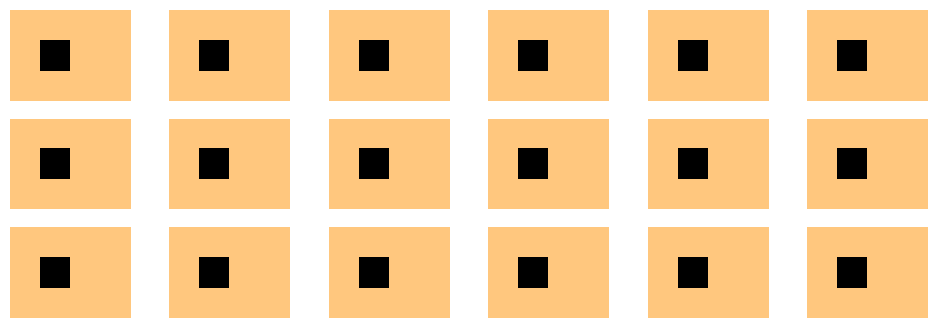

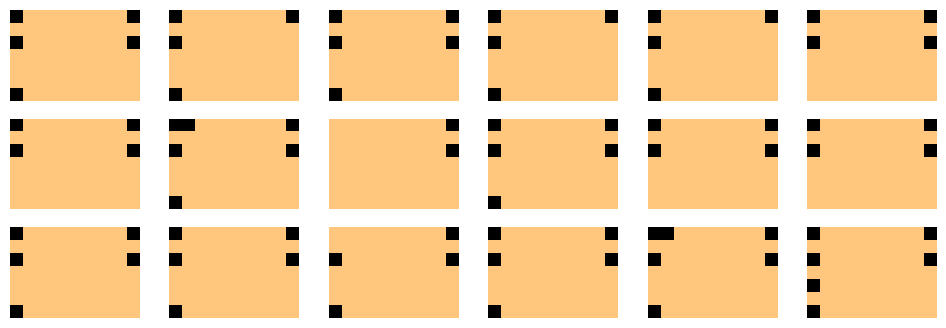

((18, 14, 24, 1), (18, 7, 10, 1), (18, 3, 4, 1), (18, 7, 10, 1))

In [67]:
generated_cons_pl = generated_languages[:, 0:14, 0:24 :]
generated_cons_npl = generated_languages[:, 15:22, 0:10 :]
generated_cons_coart = generated_languages[:, 15:18, 10:14 :]
generated_vowels = generated_languages[:, 15:22, 14:24 :]

display_rows(generated_languages, cmap="copper_r", r=3, c=6, size=(12, 6))


display_rows(generated_cons_pl, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_cons_npl, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_cons_coart, cmap="copper_r", r=3, c=6, size=(12, 4))
display_rows(generated_vowels, cmap="copper_r", r=3, c=6, size=(12, 4))

generated_cons_pl.shape, generated_cons_npl.shape, generated_cons_coart.shape, generated_vowels.shape

In [68]:
def create_ipa_table(lang, tbl):
    phonemes = np.where(lang > 0, tbl.replace(np.nan, "*").replace("", "*"), np.full(lang.shape, "_")).astype(str)
    return pd.DataFrame(
        np.char.add(
            np.char.add(phonemes[:,0::2], np.full(phonemes[:,0::2].shape, " ")),
            phonemes[:,1::2]
        ), 
        index=tbl.index, 
        columns=tbl.columns[0::2]
    )

sample_cons_pl_tbl = create_ipa_table(np.squeeze(generated_cons_pl[0]), cons_pl_tbl_df)

display(sample_cons_pl_tbl)

sample_cons_npl_tbl = create_ipa_table(np.squeeze(generated_cons_npl[0]), cons_npl_tbl_df)

display(sample_cons_npl_tbl)

sample_cons_coart_tbl = create_ipa_table(np.squeeze(generated_cons_coart[0]), cons_coart_tbl_df)

display(sample_cons_coart_tbl)

sample_vowels_tbl = create_ipa_table(np.squeeze(generated_vowels[0]), vowels_tbl_df)

display(sample_vowels_tbl)

,Bilabial,Labiodental,Linguolabial,Dental,Alveolar,Postalveolar,Retroflex,Palatal,Velar,Uvular,Pharyngeal,Glottal
Nasal,_ m,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ ŋ,_ _,_ _,_ _
Plosive,p b,_ _,_ _,t̪ d̪,t _,_ _,ʈ ɖ,c _,k ɡ,_ _,_ _,_ _
Sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant affricate,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Sibilant fricative,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Non-sibilant fricative,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Approximant,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Tap/flap,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Trill,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _
Fricative,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,_ _,h _


,Bilabial,Dental,Palato-alveolar,Palatal,Uvular
Ejective Stop,_ _,_ _,_ _,_ _,_ _
Ejective Fricative,_ _,_ _,_ _,_ _,_ _
Ejective Affricate,_ _,_ _,_ _,_ _,_ _
Ejective Lateral,_ _,_ _,_ _,_ _,_ _
Click,_ _,_ _,_ _,_ _,_ _
Implosive Voiced,_ _,_ _,_ _,_ _,_ _
Implosive Voiceless,_ _,_ _,_ _,_ _,_ _


,Labial–palatal,Velarized alveolar
Fricative,_ _,_ _
Approximant,_ w,_ _
Lateral approximant,_ _,_ _


,Front unrounded,Near-front unrounded,Central unrounded,Near-back unrounded,Back unrounded
Close,i _,_ _,_ _,_ _,_ u
Near-close,_ _,_ _,_ _,_ _,_ _
Close-mid,e _,_ _,_ _,_ _,_ o
Mid,_ _,_ _,_ _,_ _,_ _
Open-mid,_ _,_ _,_ _,_ _,_ _
Near-open,_ _,_ _,_ _,_ _,_ _
Open,a _,_ _,_ _,_ _,_ _
